In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


def prepare_dataframe(ticker, start_date="2014-01-01"):
    df = yf.download(ticker, start=start_date)
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df


def normalize_prices(data1, data2, label1, label2):
    data = pd.concat([data1['Close'], data2['Close']], axis=1).dropna()
    data.columns = [label1, label2]
    data = data / data.iloc[0]
    return data


def least_sqrs_regression(data, label1, label2):
    # Extracting data and adding a constant term
    y = data[label1].values
    X = data[label2].values
    X = np.vstack([np.ones(len(X)), X]).T  # Add a constant term

    # Perform the least squares regression using the normal equation
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)

    # Calculate residuals
    data['residuals'] = y - (beta[0] + beta[1] * data[label2])
    return data, beta


def plot_residuals(data, label1, label2):
    plt.figure(figsize=(12, 8))

    # Plot normalized prices
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data[label1], label=f'{label1} Normalized', color='blue')
    plt.plot(data.index, data[label2], label=f'{label2} Normalized', color='orange')
    plt.title(f"Normalized Prices of {label1} and {label2}")
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)

    # Plot residuals
    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['residuals'], label='Residuals', color='green')
    plt.axhline(data['residuals'].mean(), color='red', linestyle='--', label='Mean $\mu$')
    plt.axhline(data['residuals'].mean() + 1.1 * data['residuals'].std(), color='purple', linestyle='--',
                label='1.1$\sigma$')
    plt.axhline(data['residuals'].mean() - 1.1 * data['residuals'].std(), color='purple', linestyle='--')
    plt.title(f"Residuals of {label1} and {label2}")
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def perform_adf_test(residuals, significance_level=0.01):
    adf_test = adfuller(residuals)
    adf_statistic, p_value = adf_test[0], adf_test[1]

    print(f"ADF Statistic: {adf_statistic}")
    print(f"p-value: {p_value}")

    if p_value < significance_level:
        print(f"The residuals are stationary (reject null hypothesis) "
              f"at the {significance_level * 100}% significance level.")
    else:
        print(f"The residuals are not stationary (accept null hypothesis) "
              f"at the {significance_level * 100}% significance level.")

    return adf_test


def analyze_cointegration(ticker1, ticker2, start_date="2014-01-01"):
    # Prepare data
    df1 = prepare_dataframe(ticker1, start_date)
    df2 = prepare_dataframe(ticker2, start_date)

    # Normalize prices
    data = normalize_prices(df1, df2, ticker1, ticker2)

    # Perform ordinary least square (OLS) regression
    data, beta = least_sqrs_regression(data, ticker1, ticker2)

    # Plot residuals
    plot_residuals(data, ticker1, ticker2)

    # Perform ADF test
    adf_test_result = perform_adf_test(data['residuals'])
    return data, beta, adf_test_result

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


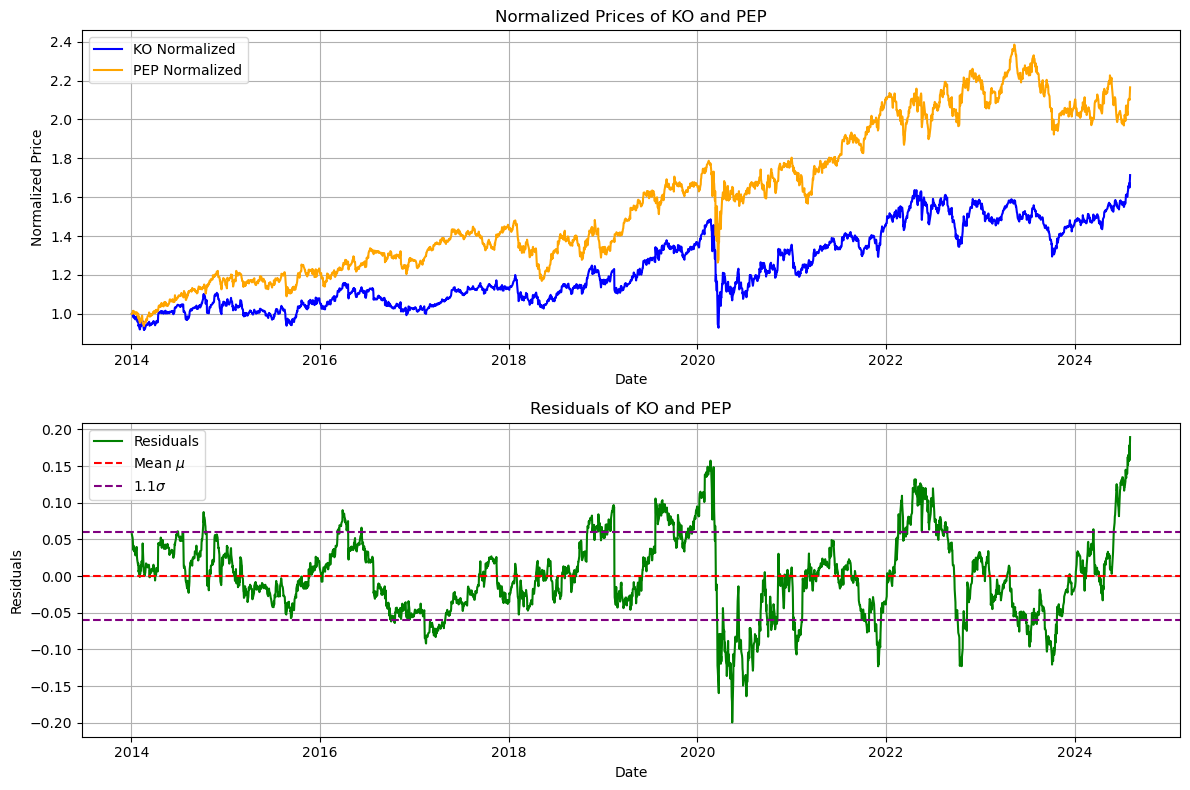

ADF Statistic: -3.830451303983788
p-value: 0.0026106811751381944
The residuals are stationary (reject null hypothesis) at the 1.0% significance level.


(                  KO       PEP  residuals
 Date                                     
 2014-01-03  1.000000  1.000000   0.057217
 2014-01-06  0.995304  1.000486   0.052279
 2014-01-07  0.998270  1.015078   0.047964
 2014-01-08  0.987148  1.012160   0.038298
 2014-01-09  0.981957  1.007417   0.035474
 ...              ...       ...        ...
 2024-07-29  1.651755  2.106153   0.157031
 2024-07-30  1.672763  2.105788   0.178221
 2024-07-31  1.649530  2.099587   0.158083
 2024-08-01  1.679684  2.127432   0.174342
 2024-08-02  1.713544  2.164883   0.189515
 
 [2663 rows x 3 columns],
 array([0.44380882, 0.49897387]),
 (-3.830451303983788,
  0.0026106811751381944,
  9,
  2653,
  {'1%': -3.432817259126433,
   '5%': -2.8626300496109773,
   '10%': -2.5673502709390714},
  -17089.691876540503))

In [31]:
# Coca-Cola and Pepsi
analyze_cointegration("KO", "PEP")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


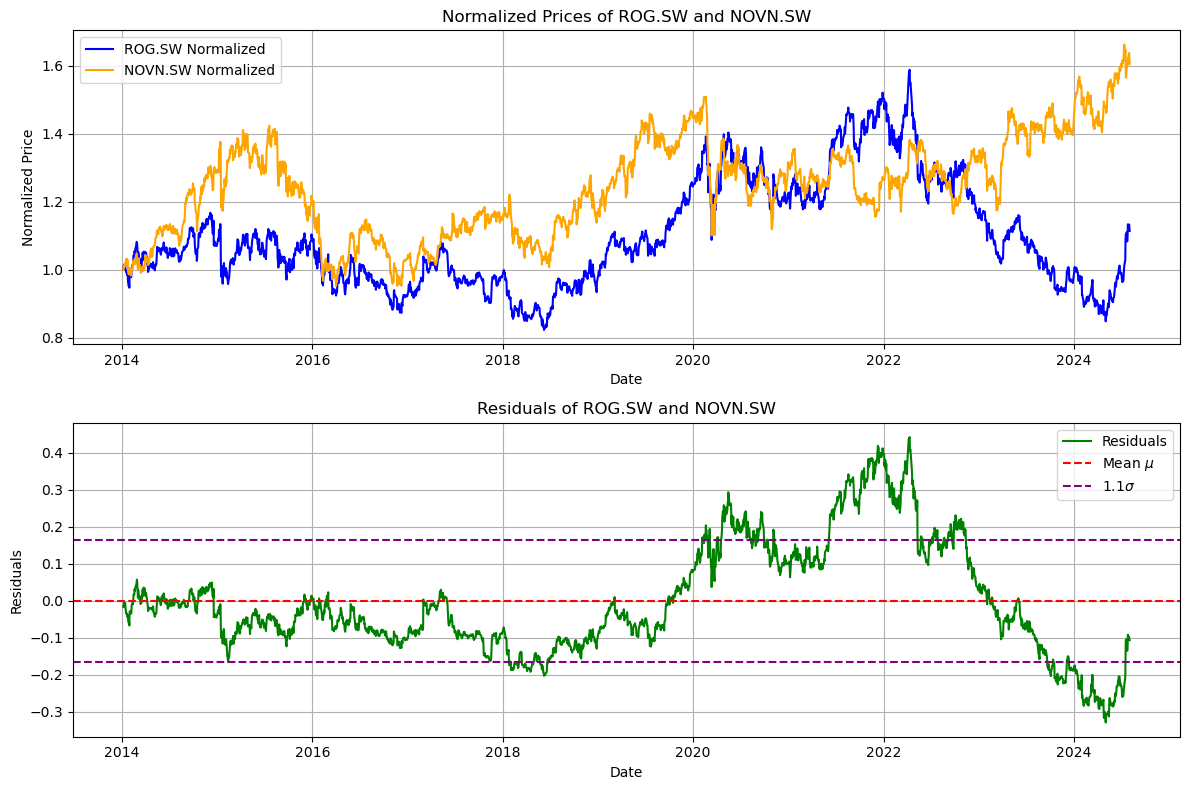

ADF Statistic: -1.9300216420930547
p-value: 0.31807241814405846
The residuals are not stationary (accept null hypothesis) at the 1.0% significance level.


(              ROG.SW   NOVN.SW  residuals
 Date                                     
 2014-01-06  1.000000  1.000000  -0.016640
 2014-01-07  1.007137  1.004175  -0.010911
 2014-01-08  1.014274  1.011134  -0.006122
 2014-01-09  1.010309  1.005567  -0.008209
 2014-01-10  1.015464  1.017397  -0.007046
 ...              ...       ...        ...
 2024-07-26  1.134021  1.618805  -0.091439
 2024-07-29  1.131642  1.629104  -0.097294
 2024-07-30  1.132038  1.635915  -0.099195
 2024-07-31  1.133228  1.637576  -0.098567
 2024-08-02  1.114592  1.604851  -0.106159
 
 [2660 rows x 3 columns],
 array([0.67918263, 0.33745691]),
 (-1.9300216420930547,
  0.31807241814405846,
  0,
  2659,
  {'1%': -3.432811686398781,
   '5%': -2.8626275885637775,
   '10%': -2.5673489606664854},
  -15967.999604586377))

In [32]:
analyze_cointegration('ROG.SW', "NOVN.SW")

In [21]:
# Prepare the data
def prepare_dataframe(ticker):
    df = yf.download(ticker, start="2014-01-01")
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df


ticker = "TSLA"
df1 = prepare_dataframe(ticker)
df1.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2014-01-03,10.000000,10.146000,9.906667,9.970667,9.970667,70425000,-0.003598
2014-01-06,10.000000,10.026667,9.682667,9.800000,9.800000,80416500,-0.017117
2014-01-07,9.841333,10.026667,9.683333,9.957333,9.957333,75511500,0.016054
2014-01-08,9.923333,10.246667,9.917333,10.085333,10.085333,92448000,0.012855
2014-01-09,10.166667,10.228667,9.790000,9.835333,9.835333,80730000,-0.024788


In [22]:
ticker = "NOVN.SW"
df2 = prepare_dataframe(ticker)
df2.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2014-01-06,60.114941,60.324398,59.905479,60.198723,38.628124,4909097,0.002791
2014-01-07,60.324398,60.701427,60.114941,60.450073,38.789410,5626716,0.004175
2014-01-08,60.617641,60.952778,60.450073,60.868996,39.058224,6095478,0.006930
2014-01-09,60.617641,61.246021,60.450073,60.533859,38.843174,5333768,-0.005506
2014-01-10,61.246021,61.581158,61.036564,61.246021,39.300156,6038558,0.011765
